In [1]:
import cv2
import numpy as np
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(7, 5)

In [2]:
equirectangular_image = cv2.imread("C:/Users/paulo/Pictures/equi2.png", cv2.IMREAD_COLOR)

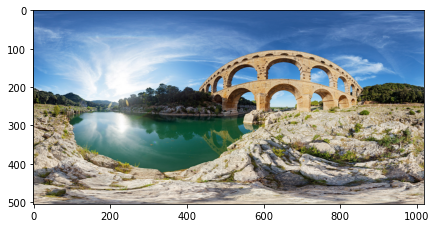

In [3]:
plt.imshow(cv2.cvtColor(equirectangular_image, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
eq_h, eq_w, _ =  equirectangular_image.shape

eq_cx = eq_w // 2.0
eq_cy = eq_h // 2.0

They should be equal

In [5]:
delta = 180/eq_h
#delta_w = eq_w/360

In [6]:
print(f'{delta} degrees per pixel')

0.3564356435643564 degrees per pixel


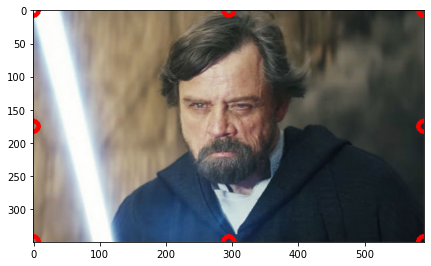

In [7]:
### bounding points ###
face_image = cv2.imread("C:/Users/paulo/Pictures/sw.jpg", cv2.IMREAD_COLOR)

h, w, _ = face_image.shape

p1 = (0,0) #top #left
p2 = (0, int(w/2)) #top center
p3 = (0, w-1) #top #right
p4 = (int(h/2), 0) #left center
p5 = (int(h/2), w-1) #right center
p6 = (h-1, 0) #bottom #left
p7 = (h-1, int(w/2)) #bottom center
p8 = (h-1, w-1) #bottom #right

points = [p1,p2,p3,p4,p5,p6,p7,p8]

test = face_image.copy()

for i, p in enumerate(points):
    
    test = cv2.circle(test, (p[1],p[0]), 8, (0,0,255), 5)
    
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
#assuming that the height of the image projected is 1

r_h = 1
r_w = (face_image.shape[1]/face_image.shape[0])*r_h

In [9]:
def polar_to_3d(dphi, dtheta): #in radians
    '''
    p0 = np.array([1,0,0], np.float32)
    y_axis = np.array([0.0, 1.0, 0.0], np.float32)*dphi
    z_axis = np.array([0.0, 0.0, 1.0], np.float32)*dtheta
    M1 = cv2.Rodrigues(y_axis)[0]
    M2 = cv2.Rodrigues(z_axis)[0]
    M = np.dot(M1,M2)
    p1 = np.dot(p0, M)
    '''
    
    p_x = np.cos(dphi) * np.cos(dtheta);
    p_y = np.cos(dphi) * np.sin(dtheta);
    p_z = np.sin(dphi);

    p1 = np.array([p_x,p_y,p_z])    
        
    return p1

In [10]:
def get_rotation_matrices(phi, theta): #in radians
    
    ## matrix to rotate. First y, then z
    y_axis = np.array([0.0, 1.0, 0.0], np.float32)*phi
    z_axis = np.array([0.0, 0.0, 1.0], np.float32)*theta

    M1 = cv2.Rodrigues(y_axis)[0]
    M2 = cv2.Rodrigues(z_axis)[0]
    M = np.dot(M1,M2)
    
    # matrix to inverse rotation
    y_axis = np.array([0.0, 1.0, 0.0], np.float32)*(-phi)
    z_axis = np.array([0.0, 0.0, 1.0], np.float32)*(-theta)

    M1_inv = cv2.Rodrigues(z_axis)[0]
    M2_inv = cv2.Rodrigues(y_axis)[0]
    M_inv = np.dot(M1_inv,M2_inv)
    
    return M, M_inv

In [11]:
phi = np.radians(90)
theta = np.radians(0)

M, M_inv = get_rotation_matrices(phi, theta)

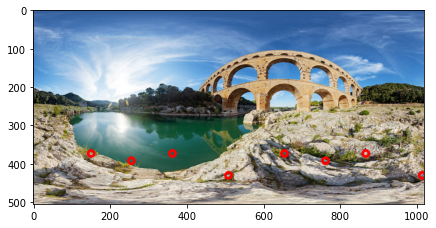

In [12]:
test = equirectangular_image.copy()  

eq_bound = []

for p in points:
    py, px = p
    py = (py/face_image.shape[0])*r_h
    px = (px/face_image.shape[1])*r_w
    
    py = py - r_h/2
    px = px - r_w/2
    
    ptheta = np.arctan(px)
    pphi = np.arctan(py)
    
    p1 = polar_to_3d(pphi, ptheta)
    
    p1 = np.dot(p1, M)
    
    ntheta = np.degrees(np.arctan2(p1[1], p1[0]))
    nphi = np.degrees(np.arcsin(p1[2]))
    
    x = (ntheta/delta)+eq_cx
    y = (nphi/delta)+eq_cy
    x = int(np.round(x))
    y = int(np.round(y))
    
    test = cv2.circle(test, (x,y), 8, (0,0,255), 5)
    
    eq_bound.append((y,x))
    
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
top = min([y[0] for y in eq_bound[:3]])
bottom = max([y[0] for y in eq_bound[-3:]])
left = min([eq_bound[0][1],eq_bound[3][1], eq_bound[5][1]]) #1,4,6
right = max([eq_bound[2][1],eq_bound[4][1], eq_bound[7][1]])#3,5,8

top_center = eq_bound[1][1]%(eq_w-1)
bottom_center = eq_bound[6][1]%(eq_w-1)
alpha = 5 #tolerance of difference

if abs(top_center - bottom_center) < alpha: #they are aligned
    
    if right < left:
        part1 = np.arange(left, eq_w)
        part2 = np.arange(0, right+1)
        x_range = np.concatenate((part1,part2))    
    else:
        x_range = np.arange(left, right+1)
        
    y_range = np.arange(top, bottom+1)

else: #they are not aligned, close to the poles
    x_range = np.arange(0, eq_w)
    
    if phi > 0: #down
        y_range = np.arange(top, eq_h)
    else: #up
        y_range = np.arange(0, bottom+1)

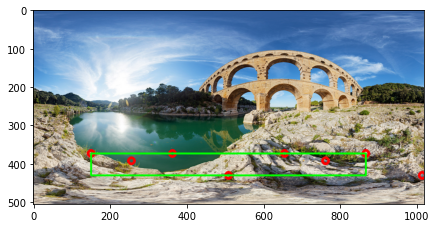

In [14]:
test = cv2.rectangle(test, (left, bottom), (right, top), (0,255,0), 3)
plt.imshow(cv2.cvtColor(test, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
for i in y_range:
#for i in range(eq_h):
    for j in x_range:
    #for j in range(eq_w):
        
        dtheta = np.radians((j - eq_cx)*delta)
        dphi = np.radians((i - eq_cy)*delta)
        
        p1 = np.dot(polar_to_3d(dphi, dtheta), M_inv)
        
        dtheta = np.arctan2(p1[1], p1[0]);
        dphi = np.arcsin(p1[2])
        
        tanx = np.tan(dtheta) + r_w/2
        tany = np.tan(dphi) + r_h/2

        if tanx >= 0 and tanx <= r_w and tany>=0 and tany<=r_h:

            posx = int((tanx/r_w) * face_image.shape[1])
            posy = int((tany/r_h) * face_image.shape[0])               
            equirectangular_image[i,j] = face_image[posy, posx]
        else:
            equirectangular_image[i,j] = [255, 0, 0]

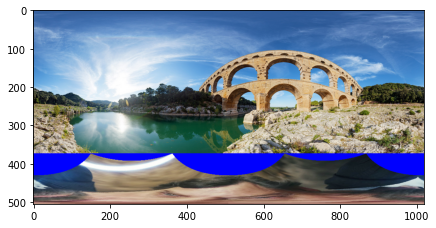

In [16]:
plt.imshow(cv2.cvtColor(equirectangular_image, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
top

373